# Is it independent?



In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate

In [35]:
from scipy.stats import gaussian_kde

observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]) / 60

# distribution of times between trains
kde_gap = gaussian_kde(observed_gap_times)

# distribution of times between trains as seen by random arrival
kde_prior = gaussian_kde(observed_gap_times, weights=observed_gap_times)

Here are the distributions.

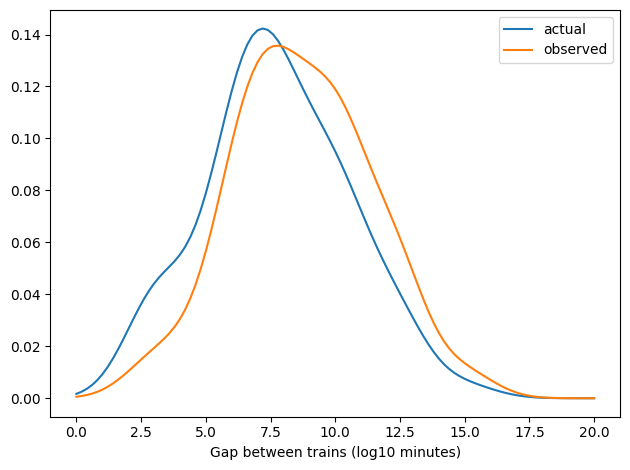

In [37]:
import matplotlib.pyplot as plt

def plot_kde(kde, **options):
    xs = np.linspace(0, 20, 101)
    ps = kde(xs)
    plt.plot(xs, ps, **options) 
             
plot_kde(kde_gap, label='actual')
plot_kde(kde_prior, label='observed')

decorate(xlabel='Gap between trains (log10 minutes)')

In [40]:
log_sample = np.log10(observed_gap_times)

m, s = np.mean(log_sample), np.std(log_sample)
m, s

(0.8590533907508388, 0.17436593870523054)

In [121]:
mu = 2
sigma = 0.2

alpha = (mu/sigma)**2
beta = mu / sigma**2

alpha, beta

(100.0, 49.99999999999999)

In [122]:
from scipy.stats import gamma

scale = 1 / beta
gamma_dist = gamma(a=alpha, scale=scale)
gamma_dist.mean(), gamma_dist.std()

(2.0000000000000004, 0.20000000000000004)

In [134]:
import pymc as pm  

def make_model(n_obs=10):

    model = pm.Model()
    with model:
        log_time = pm.StudentT('log_time', mu=m, sigma=s, nu=7)
        gap_time = pm.Deterministic('gap_time', 10 ** log_time)
        elapsed_time = pm.Uniform('elapsed_time', lower=0, upper=gap_time)

        rate = pm.Gamma('rate', alpha=alpha, beta=beta)
        mu = elapsed_time * rate
        n = pm.Poisson('n', mu=mu, observed=n_obs)
        
    return model

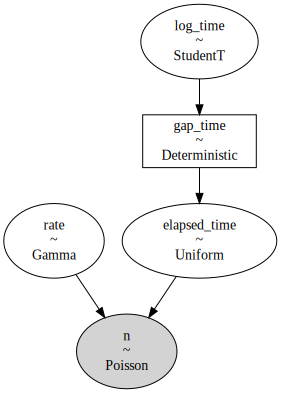

In [136]:
model = make_model(n_obs=10)
pm.model_to_graphviz(model)

In [137]:
with model:
    idata = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_time, elapsed_time, rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


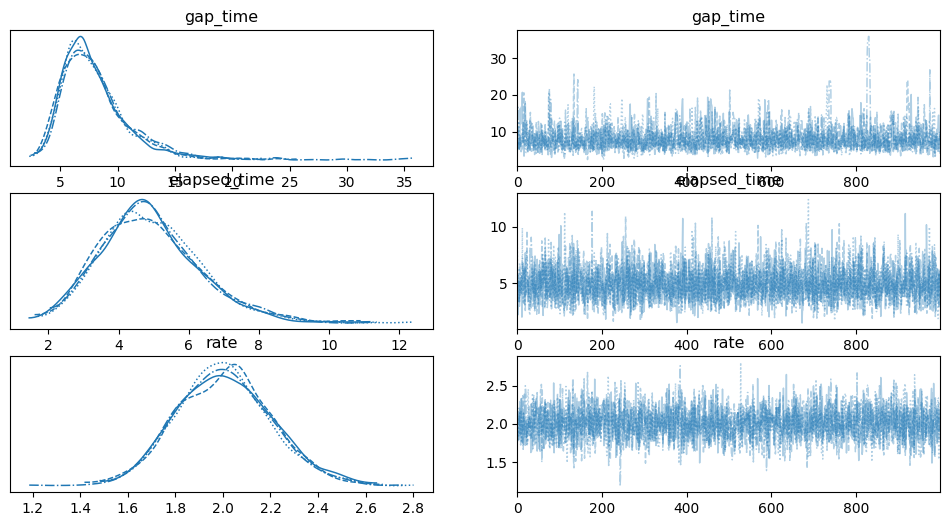

In [141]:
import arviz as az

var_names=['gap_time', 'elapsed_time', 'rate']

with model:
    az.plot_trace(idata, var_names=var_names)

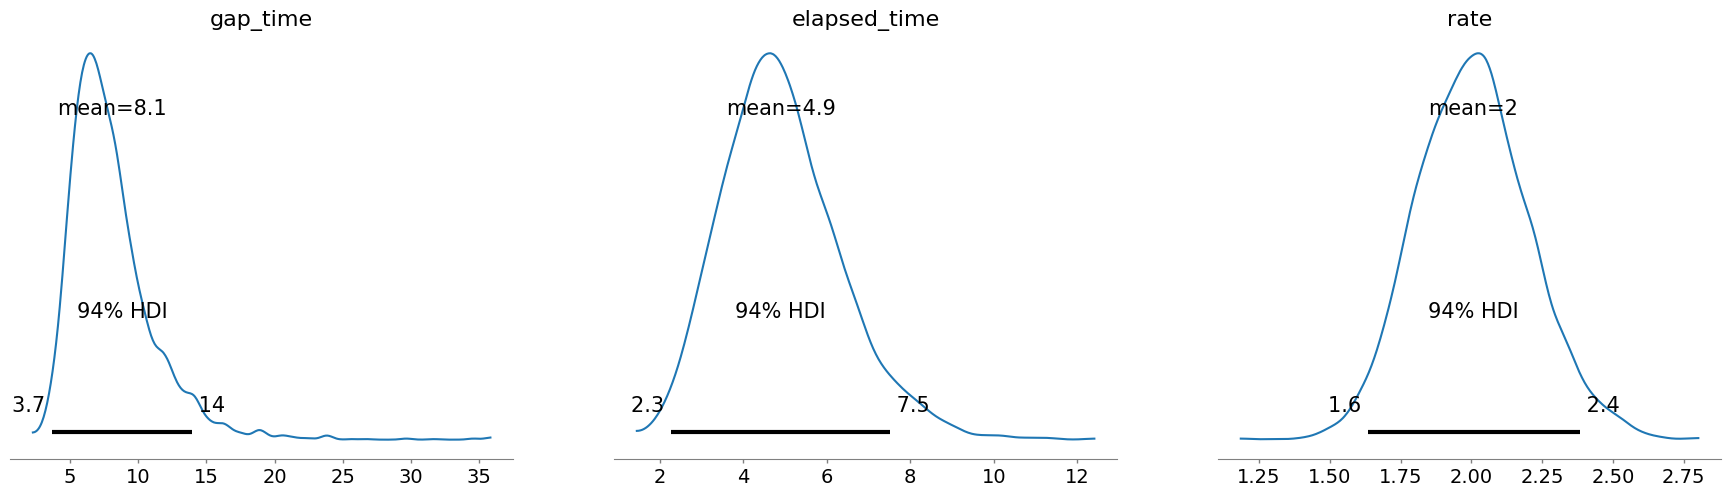

In [142]:
import arviz as az

with model:
    az.plot_posterior(idata, var_names=var_names)

In [143]:
def get_sample(idata, var_name):
    return idata.posterior[var_name].values.flatten()

rates = get_sample(idata, 'rate')
np.mean(rates)

2.0053630428235634

In [144]:
gap_times = get_sample(idata, 'gap_time')
np.mean(gap_times)

8.094949565334511

In [145]:
elapsed_times = get_sample(idata, 'elapsed_time')
np.mean(elapsed_times)

4.915920179938246

In [150]:
np.corrcoef([gap_times, elapsed_times, rates])

array([[ 1.        ,  0.30019357, -0.0529999 ],
       [ 0.30019357,  1.        , -0.25373678],
       [-0.0529999 , -0.25373678,  1.        ]])

In [151]:
remaining_times = gap_times - elapsed_times
np.mean(remaining_times)

3.179029385396267

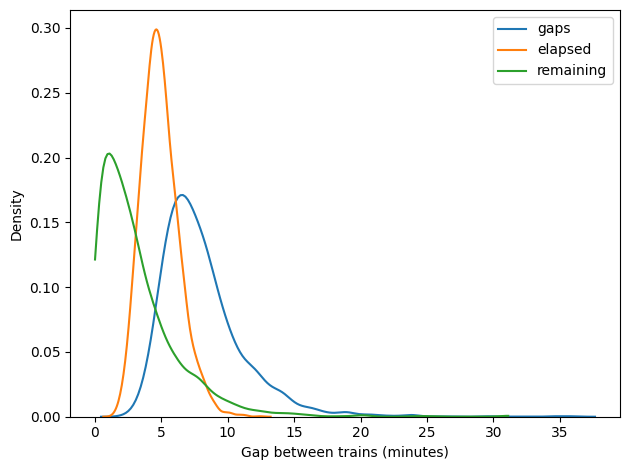

In [152]:
import seaborn as sns

sns.kdeplot(gap_times, label='gaps')
sns.kdeplot(elapsed_times, label='elapsed')
sns.kdeplot(remaining_times, label='remaining', cut=0)

decorate(xlabel='Gap between trains (minutes)')

Think Bayes, Second Edition

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)